# random forest로 Bank Marketing 예측
# (은행에서 실시한 고객 마케팅 성과를 예측하기)

이 노트북에서는 다음을 수행합니다.
- Pandas를 사용하여 데이터 세트의 원-핫 인코딩 수행
- scikit-learn을 사용하여 Random Forest 모델 구현

사용할 라이브러리를 가져와 보겠습니다.

In [51]:
# 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. 데이터셋 로드 및 확인

From https://archive.ics.uci.edu/dataset/222/bank+marketing)

이 데이터는 은행이 고객에게 전화로 마케팅 캠페인을 진행한 결과를 바탕으로 만들어졌습니다. 목표는 고객이 은행의 정기예금 상품을 구독했는지 여부를 예측하는 것입니다. 이 데이터는 은행이 캠페인의 효율성을 분석하고, 자원을 효과적으로 활용하여 더 나은 마케팅 전략을 수립하는 데 도움이 됩니다.

은행의 캠페인 데이터는 다양한 고객 정보, 상호작용 이력, 경제적 지표를 포함하며, 이를 통해 정기예금 가입 가능성을 예측하는 모델을 개발할 수 있습니다.

아래의 데이터를 기반으로, 특정 고객이 은행의 정기예금 상품을 구독할 가능성을 예측하는 머신러닝 모델을 개발합니다. 이를 통해 은행은 고객 타겟팅을 개선하고 캠페인의 성공률을 높일 수 있습니다.

#### Attribute Information
- 나이(Age): 고객의 나이 [정수]
- 직업(Job): 고객의 직업 유형 [admin., technician, blue-collar 등]
- 결혼 상태(Marital): 고객의 결혼 상태 [married, single, divorced]
- 교육(Education): 교육 수준 [basic.4y, high.school 등]
- 신용불량(Default): 신용 불량 여부 [yes, no]
- 주택 대출(Housing): 주택 대출 여부 [yes, no]
- 개인 대출(Loan): 개인 대출 여부 [yes, no]
- 연락 방식(Contact): 고객과의 연락 방식 [cellular, telephone 등]
- 지난 통화 길이(Duration): 가장 최근 통화의 길이(초 단위)
- 캠페인 연락 횟수(Campaign): 현재 캠페인에서 고객에게 연락한 횟수
- 이전 캠페인 결과(Poutcome): 이전 캠페인의 결과 [success, failure, nonexistent]
- 경제 지표: 고용 변동률, 소비자 물가 지수, 소비자 신뢰 지수, 3개월 유리보 금리 등

이제 데이터 세트를 로드해 보겠습니다. 


In [53]:
# 데이터 다운로드 및 로드
url = r"C:\Users\Owner\Downloads\bank+marketing\bank\bank-full.csv"
data = pd.read_csv(url, sep=';')

In [55]:
# 데이터의 첫 몇 행 출력
print("데이터 개요:")
print(data.head())

데이터 개요:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  


In [57]:
# 결측값 확인
print("\n결측값 확인:")
print(data.isnull().sum())  # 각 열별 결측값 개수를 확인


결측값 확인:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


결측값을 확인하는 이유는 데이터에 결측값이 있는지, 어느 열에 결측값이 있는지, 결측값의 개수는 얼마나 되는지 확인하기 위함입니다. 데이터 분석과 머신러닝 모델링에서는 결측값을 적절히 처리해야 하기 때문에 이 작업은 매우 중요합니다.

# 2.범주형 변수 원-핫 인코딩
범주형 변수는 원-핫 인코딩을 통해 이진 변수들로 변환해야 합니다. 원-핫 인코딩은 n 출력을 갖는 범주형 변수를 n 이진 변수로 변환하는 것을 목표로 합니다.

In [59]:
# 범주형 변수 원-핫 인코딩
data_encoded = pd.get_dummies(data, drop_first=True)  # 원-핫 인코딩 수행, 첫 번째 범주 제거(drop_first=True)

# 3. 독립 변수(X)와 종속 변수(y) 분리
종속 변수(y_yes, 'yes'로 응답한 사람들)를 y로 설정하고, 나머지 열들을 X(독립 변수)로 설정합니다.

In [61]:
# 독립 변수(X)와 종속 변수(y) 분리
X = data_encoded.drop("y_yes", axis=1)  # 'y_yes' 열 제외하고 나머지는 독립 변수
y = data_encoded["y_yes"]  # 종속 변수는 'y_yes'

# 4. 데이터 분리
데이터를 70%는 학습용, 30%는 테스트용으로 나눕니다. random_state=42는 동일한 결과를 재현하기 위해 설정합니다.

random_state=42는 랜덤성을 제어하기 위한 설정으로, 머신러닝에서 데이터를 무작위로 분리하거나 모델 내부에서 무작위성을 사용하는 알고리즘의 결과를 재현 가능하게 만듭니다.
- random_state는 이러한 랜덤성을 고정된 시드 값(seed value)으로 설정하여, 무작위의 과정이 사실상 동일하게 작동하도록 만듭니다.
    - random_state에 특정 값을 설정하면:
        - 고정된 시드가 설정됩니다.
        - 이 시드를 기준으로 무작위성이 결정되며, 이후의 무작위한 연산은 동일한 순서로 실행됩니다.
        - 같은 코드를 여러 번 실행해도 결과가 동일합니다.

In [63]:
# 데이터 분리 (학습 데이터와 테스트 데이터로 나눔)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # 70:30 비율로 분리

# 5. 하이퍼파라미터 튜닝을 위한 리스트 설정
랜덤 포레스트 모델의 하이퍼파라미터를 튜닝하기 위한 값들을 리스트로 설정합니다:
- min_samples_split: 분할을 위해 필요한 최소 샘플 수
- max_depth: 트리의 최대 깊이
- n_estimators: 사용할 트리의 개수
  
  
모델의 정확도를 기록하기 위해 두 개의 빈 리스트를 생성합니다.
- accuracy_list_train:학습 데이터(X_train, y_train)에 대한 모델의 정확도를 기록합니다.
- accuracy_list_test:테스트 데이터(X_test, y_test)에 대한 모델의 정확도를 기록합니다.

In [66]:
# 하이퍼파라미터 리스트
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700]
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10, 50, 100, 500]

In [68]:
# 정확도 기록을 위한 리스트
accuracy_list_train = []
accuracy_list_test = []

# 6. 하이퍼파라미터 튜닝 - min_samples_split
머신러닝 모델의 성능을 최적화하고, 데이터에 대한 모델의 일반화 능력을 향상시키기 위해서입니다. 모델의 하이퍼파라미터는 모델의 동작 방식을 크게 좌우하므로 적절히 조정해야 최상의 결과를 얻을 수 있습니다.

- 모델의 하이퍼파라미터는 기본값으로 설정되어 있지만, 이 값들이 항상 최적의 성능을 보장하지 않습니다.
튜닝을 통해 모델이 데이터에 적합한 설정을 찾을 수 있습니다.
- 과적합(Overfitting) 및 과소적합(Underfitting) 방지합니다.
- 모델이 새로운 데이터에 대해 더 잘 일반화하도록 하이퍼파라미터를 조정합니다.
- 모델이 학습하는 데이터의 특성에 따라 적합한 하이퍼파라미터 값이 달라집니다.


아래는 min_samples_split 값을 바꾸며 모델을 학습시키고, 학습 데이터와 테스트 데이터에 대한 정확도를 기록합니다. 이후 정확도를 그래프로 시각화합니다.

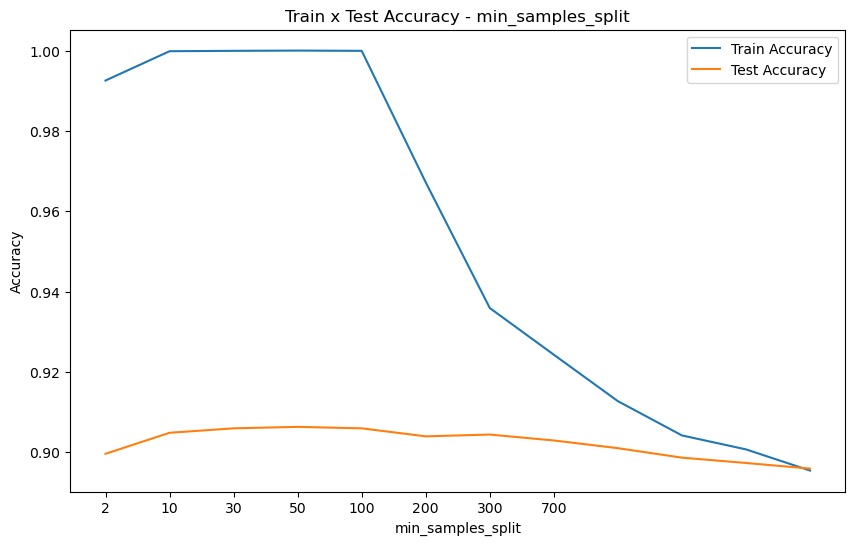

In [98]:
# min_samples_split 튜닝
for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split=min_samples_split, random_state=42)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_test = accuracy_score(predictions_test, y_test)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.figure(figsize=(10, 6))
plt.title('Train x Test Accuracy - min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train, label='Train Accuracy')
plt.plot(accuracy_list_test, label='Test Accuracy')
plt.legend()
plt.show()

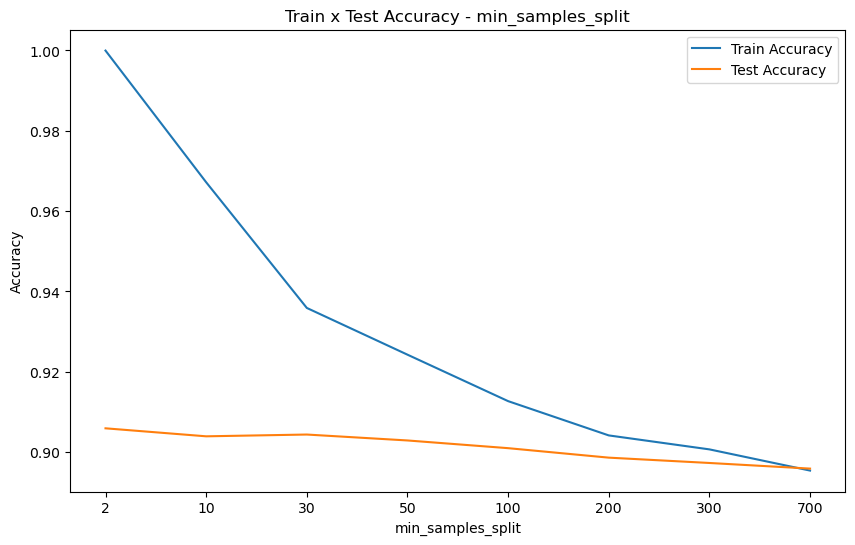

In [70]:
# min_samples_split 튜닝
for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split=min_samples_split, random_state=42)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_test = accuracy_score(predictions_test, y_test)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.figure(figsize=(10, 6))
plt.title('Train x Test Accuracy - min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train, label='Train Accuracy')
plt.plot(accuracy_list_test, label='Test Accuracy')
plt.legend()
plt.show()

# 7. 하이퍼파라미터 튜닝 - max_depth
max_depth 값을 바꾸며 모델을 학습시키고, 학습 데이터와 테스트 데이터에 대한 정확도를 기록합니다. 이후 정확도를 그래프로 시각화합니다.

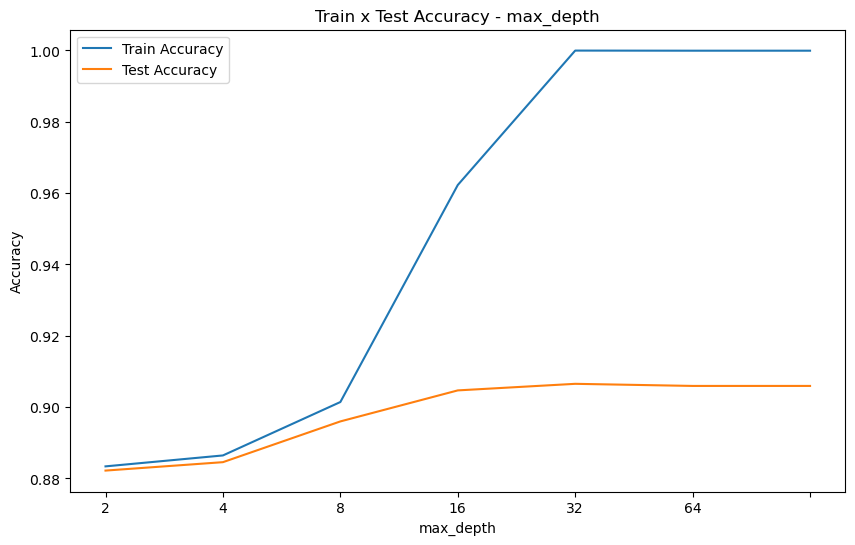

In [72]:
# max_depth 튜닝
accuracy_list_train = []
accuracy_list_test = []

for max_depth in max_depth_list:
    model = RandomForestClassifier(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_test = accuracy_score(predictions_test, y_test)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.figure(figsize=(10, 6))
plt.title('Train x Test Accuracy - max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(accuracy_list_train, label='Train Accuracy')
plt.plot(accuracy_list_test, label='Test Accuracy')
plt.legend()
plt.show()

# 8. 하이퍼파라미터 튜닝 - n_estimators
n_estimators 값을 바꾸며 모델을 학습시키고, 학습 데이터와 테스트 데이터에 대한 정확도를 기록합니다. 이후 정확도를 그래프로 시각화합니다.

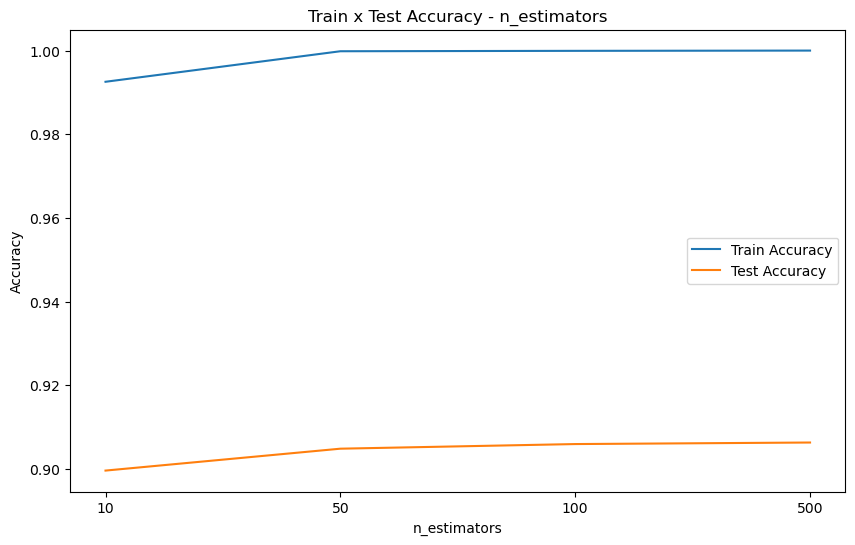

In [74]:
# n_estimators 튜닝
accuracy_list_train = []
accuracy_list_test = []

for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_test = accuracy_score(predictions_test, y_test)
    
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.figure(figsize=(10, 6))
plt.title('Train x Test Accuracy - n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.plot(accuracy_list_train, label='Train Accuracy')
plt.plot(accuracy_list_test, label='Test Accuracy')
plt.legend()
plt.show()

# 9. 최종 모델 학습
하이퍼파라미터 튜닝 후 선택한 값들로 최종 모델을 학습시킵니다. 여기서는 n_estimators=100, max_depth=8, min_samples_split=10이 사용되었습니다.

In [76]:
# 최종 모델 학습 (하이퍼파라미터 튜닝 후 선택)
final_model = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=10, random_state=42)
final_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=10, random_state=42)

# 10. 최종 평가
최종 모델의 성능을 평가합니다. 정확도, 혼동 행렬, 그리고 분류 보고서를 출력하여 모델의 성능을 종합적으로 평가합니다.

피처 중요도를 추출하고 상위 10개의 피처를 출력합니다.
피처 중요도를 추출하는 이유는 모델이 예측을 수행할 때 각 변수(피처)가 미치는 영향을 정량적으로 평가하고, 이를 통해 데이터를 이해하고 모델 성능을 개선하며, 비즈니스 또는 연구 목적에 활용하기 위함입니다.

In [78]:
# 최종 모델 평가
y_pred = final_model.predict(X_test)

# 모델 평가
print("\n모델 평가:")
print("정확도:", accuracy_score(y_test, y_pred))  # 정확도 출력
print("\n혼동 행렬:")
print(confusion_matrix(y_test, y_pred))  # 혼동 행렬 출력
print("\n분류 보고서:")
print(classification_report(y_test, y_pred))  # 분류 결과 요약 보고서 출력


모델 평가:
정확도: 0.8956060159245061

혼동 행렬:
[[11876    90]
 [ 1326   272]]

분류 보고서:
              precision    recall  f1-score   support

       False       0.90      0.99      0.94     11966
        True       0.75      0.17      0.28      1598

    accuracy                           0.90     13564
   macro avg       0.83      0.58      0.61     13564
weighted avg       0.88      0.90      0.87     13564



In [80]:
# 피처 중요도 추출
importances = final_model.feature_importances_  # 각 피처의 중요도 추출
features = X.columns  # 피처 이름
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})  # 데이터프레임 생성
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)  # 중요도 기준 내림차순 정렬

In [82]:
# 중요도가 높은 상위 10개 피처 출력
print("\n상위 10개 중요한 피처:")
print(feature_importance_df.head(10))


상위 10개 중요한 피처:
             Feature  Importance
3           duration    0.402770
40  poutcome_success    0.152532
5              pdays    0.059934
0                age    0.058784
24       housing_yes    0.039583
27   contact_unknown    0.034071
34         month_mar    0.026491
41  poutcome_unknown    0.025140
6           previous    0.024994
1            balance    0.023133
